# Fine-tuned ALBERT Model for Constructiveness Detection in Steam Reviews
## *Sentiment-Analysis of Videogame Reviews on the Platform ”Steam” with a Focus on the Detection and Classification of <b>Constructiveness</b>*
---
### <u>NOTEBOOK **5**/5</u>: This Notebook evaluates a range of commonly used/popular models, fine-tuned on Steam Game-Review constructivity labels, against eachother.

In [ ]:
# Package Installs
!pip install tensorflow
!pip install pandas numpy datasets transformers accelerate scikit-learn tensorboard
# PyTorch with CUDA 12.4 support
!pip3 install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu124
# Specific version of protobuf ((Ensures compatibility with the installed tensorflow version)
!pip uninstall -y protobuf
!pip install protobuf==3.20.*
!pip install matplotlib
!pip install -q wandb
!pip install seaborn

In [ ]:
# Imports
import pandas as pd
import numpy as np
from datasets import Dataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer, DataCollatorWithPadding, pipeline
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix, roc_curve, auc
from scipy.special import softmax
import torch
from datetime import datetime
import time
import wandb
import matplotlib.pyplot as plt
import os
import seaborn as sns
from google.colab import drive

In [ ]:
drive.mount('/content/drive')

In [ ]:
import sys

# Flag that automaticaly configures the notebook depending on if it is run in google colab or locally
RUNNING_IN_GOOGLE_COLAB = "google.colab" in sys.modules
print("Running in Google Colab" if RUNNING_IN_GOOGLE_COLAB else "Running locally")

Running in Google Colab


In [ ]:
# System Information
# Prints all sorts of system information (CPU, GPU, RAM, CUDA Installed, CUDA Version, RAM) about the google colab runtime
print("\033[1m" + "GPU Information" + "\033[0m")
print("- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - ")
!nvidia-smi
print()
print("\033[1m" + "CPU Information" + "\033[0m")
print("- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - ")
!cat /proc/cpuinfo
print()
print("\033[1m" + "Memory Information" + "\033[0m")
print("- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - ")
!cat /proc/meminfo
print()
print("\033[1m" + "NVidia CUDA Information" + "\033[0m")
print("- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - ")
!nvcc --version
print()
print("\033[1m"+ "CUDA Installation Check"+ "\033[0m")
print("- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - ")

import torch
torch.cuda.is_available()
try:
  print("CUDA Installation Check Result: " + "\033[3m" + torch.cuda.get_device_name(0) + "\033[3m")
except:
  if RUNNING_IN_GOOGLE_COLAB:
    print("No GPU found. You might be connected to a CPU runtime in Google Colab.")
  else:
    print("No GPU found.")

In [ ]:
# Sets seeds for reproducability
def set_seed(seed):
    np.random.seed(seed)
    torch.manual_seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)

In [ ]:
set_seed(42)

In [ ]:
# Logs into Weights & Biases Account
wandb.login()

True

In [ ]:
test_df = pd.read_csv("/content/drive/MyDrive/finetuned_models/test.csv")
test_dataset = Dataset.from_pandas(test_df)

In [ ]:
test_df

,text,label
0,Review: I'm not enjoying this anymore. This am...,1
1,Review: i love this game a great multyplayer a...,0
2,"Review: when pootis, Playtime: 4, Voted Up: Tr...",0
3,"Review: headtaps, Playtime: 57, Voted Up: True...",0
4,Review: good ⣿⣿⣿⣿⣿⣿⣿⣿⡿⠿⠛⠛⠛⠋⠉⠈⠉⠉⠉⠉⠛⠻⢿⣿⣿⣿⣿⣿⣿⣿ ⣿⣿...,0
...,...,...
142,"Review: Great i highly recommed it, Playtime: ...",0
143,"Review: The most toxic Game Ever i played !, P...",1
144,Review: Ever changing with every season. A sim...,1
145,"Review: Jbmod is trash!!!, Playtime: 65, Voted...",0


In [ ]:
def compute_metrics(pred):
  labels = pred.label_ids
  preds = pred.predictions.argmax(-1)
  f1 = f1_score(labels, preds, average="macro")
  acc = accuracy_score(labels, preds)
  precision = precision_score(labels, preds, average="macro")
  recall = recall_score(labels, preds, average="macro")
  return {"precision": precision, "recall": recall, "acc": acc, "f1": f1}

In [ ]:
# Plots confusion matrices to gauge whether the models are predicting a disproportionate amount of false positives or negatives
def plot_confusion_matrix(labels, preds, model_name):
    cm = confusion_matrix(labels, preds)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Not Constructive", "Constructive"], yticklabels=["Not Constructive", "Constructive"])
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title(f'Confusion Matrix for {model_name}')
    plt.show()

In [ ]:
# Plots a roc curve to gauge the true positive rate against the false positive rate
def plot_roc_curve(labels, probs):
    fpr, tpr, _ = roc_curve(labels, probs[:, 1])
    roc_auc = auc(fpr, tpr)
    plt.figure()
    plt.plot(fpr, tpr, color="darkorange", lw=2, label="ROC curve (area = %0.2f)" % roc_auc)
    plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("Receiver Operating Characteristic")
    plt.legend(loc="lower right")
    plt.show()

In [ ]:
# Main evaluation function which evaluates each model based on the test dataset
def evaluate_model(model_name, model_checkpoint, tokenized_test_dataset):
    # Loads the model and tokenizer
    model = AutoModelForSequenceClassification.from_pretrained(model_checkpoint)

    # Sets up evaluation TrainingArguments, which mirror the finetuning setup for reproducability
    eval_args = TrainingArguments(
        output_dir="/content/drive/MyDrive/finetuned_models/evaluation_results",
        per_device_eval_batch_size=2,
        dataloader_drop_last=False,
        logging_dir="/content/drive/MyDrive/finetuned_models/evaluation_logs",
        disable_tqdm=False,
        seed=42,
        report_to=["wandb", "tensorboard"],
        logging_steps=10,
        fp16=True
    )

    trainer = Trainer(
        model=model,
        args=eval_args,
        eval_dataset=tokenized_test_dataset,
        tokenizer=tokenizer,
        compute_metrics=compute_metrics
    )

    # Initializes a Weights & Biases run for the evaluation
    current_time = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
    run = wandb.init(
        name=f'{model_name}-evaluation-run-{current_time}',
        project=f'{model_name}-finetuned-steam-reviews-evaluation',
        sync_tensorboard=True
    )

    # Start time of the evaluation run
    start_time = time.time()

    # Runs the evaluation
    eval_results = trainer.evaluate()

    # Makes predictions based on the test dataset
    predictions = trainer.predict(tokenized_test_dataset)
    # Extracts the predictions and labels from the predictions object
    preds = predictions.predictions.argmax(-1)
    # Gets the labels from the predictions
    labels = predictions.label_ids

    # Calculates the total time taken for the evaluation of the model
    end_time = time.time()
    total_time = end_time - start_time

    # Plots the confustion matrix using the labels and predictions
    plot_confusion_matrix(labels, preds, model_name)

    # Plots the confustion matrices
    probs = softmax(predictions.predictions, axis=1)
    plot_roc_curve(labels, predictions.predictions)

    # Finishes the Weights & Biases run
    run.finish()

    return {
        "Model": model_name,
        "Accuracy": eval_results["eval_acc"],
        "F1 Score": eval_results["eval_f1"],
        "Precision": eval_results["eval_precision"],
        "Recall": eval_results["eval_recall"],
        "Evaluation Time (seconds)": total_time
    }

In [ ]:
# Tokenize function which tokenizes the steam review text
def tokenize_function(batch, tokenizer):
    return tokenizer(batch["text"], truncation=True)

In [ ]:
# Array of Dictionaries, which hold information about the models to be evaluated
models_to_evaluate = [
    {"name": "ALBERT", "checkpoint": "/content/drive/MyDrive/finetuned_models/albert-base-v2-finetuned-steam-reviews"},
    {"name": "BERT", "checkpoint": "/content/drive/MyDrive/finetuned_models/bert-base-uncased-finetuned-steam-reviews"},
    {"name": "DistilBERT", "checkpoint": "/content/drive/MyDrive/finetuned_models/distilbert-base-uncased-finetuned-steam-reviews"},
    {"name": "GPT-2", "checkpoint": "/content/drive/MyDrive/finetuned_models/gpt2-finetuned-steam-reviews"},
    {"name": "RoBERTa", "checkpoint": "/content/drive/MyDrive/finetuned_models/roberta-base-finetuned-steam-reviews"},
    {"name": "XLNet", "checkpoint": "/content/drive/MyDrive/finetuned_models/xlnet-base-cased-finetuned-steam-reviews"},
]

In [ ]:
evaluation_results = []  # Holds the evaluation results

# Loops through the dictionary and evaluates each model
for model_info in models_to_evaluate:
    model_name = model_info["name"]
    model_checkpoint = model_info["checkpoint"]

    # Reinitializes the test data
    test_dataset = Dataset.from_pandas(test_df)

    # Initializes the tokenizer for each model
    tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)

    # Tokenizes the test dataset using the specific tokenizer for the respective model
    tokenized_test_dataset = test_dataset.map(lambda batch: tokenize_function(batch, tokenizer), batched=True)

    # Evaluates the model using the main evaluation function
    results = evaluate_model(model_name, model_checkpoint, tokenized_test_dataset)
    evaluation_results.append(results)

In [ ]:
# Converts the results to a dataframe and prints it
results_df = pd.DataFrame(evaluation_results)
print("Evaluation Results:\n", results_df)

Evaluation Results:
         Model  Accuracy  F1 Score  Precision    Recall  \
0      ALBERT  0.795918  0.793771   0.800315  0.817995   
1        BERT  0.700680  0.700000   0.722222  0.730769   
2  DistilBERT  0.802721  0.792907   0.790543  0.796016   
3       GPT-2  0.795918  0.793771   0.800315  0.817995   
4     RoBERTa  0.775510  0.774004   0.786020  0.801511   
5       XLNet  0.789116  0.788135   0.804433  0.819368   

   Evaluation Time (seconds)  
0                   6.590941  
1                   5.588061  
2                   2.194274  
3                   2.855156  
4                   4.979356  
5                  17.090754  


In [ ]:
# Sorts the result dataframe and prints the sorted result
sorted_results = results_df.sort_values(by="F1 Score", ascending=False)
print("\nSorted Evaluation Results by F1 Score:\n", sorted_results)


Sorted Evaluation Results by F1 Score:
         Model  Accuracy  F1 Score  Precision    Recall  \
0      ALBERT  0.795918  0.793771   0.800315  0.817995   
3       GPT-2  0.795918  0.793771   0.800315  0.817995   
2  DistilBERT  0.802721  0.792907   0.790543  0.796016   
5       XLNet  0.789116  0.788135   0.804433  0.819368   
4     RoBERTa  0.775510  0.774004   0.786020  0.801511   
1        BERT  0.700680  0.700000   0.722222  0.730769   

   Evaluation Time (seconds)  
0                   6.590941  
3                   2.855156  
2                   2.194274  
5                  17.090754  
4                   4.979356  
1                   5.588061  


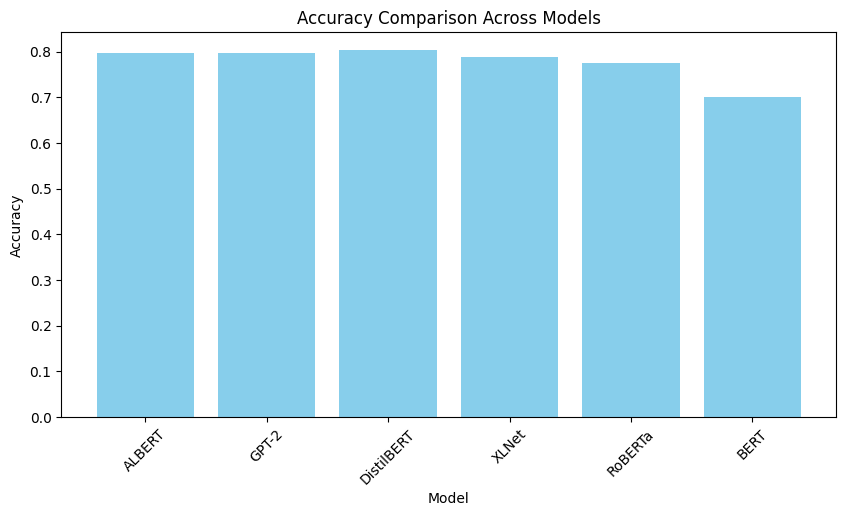

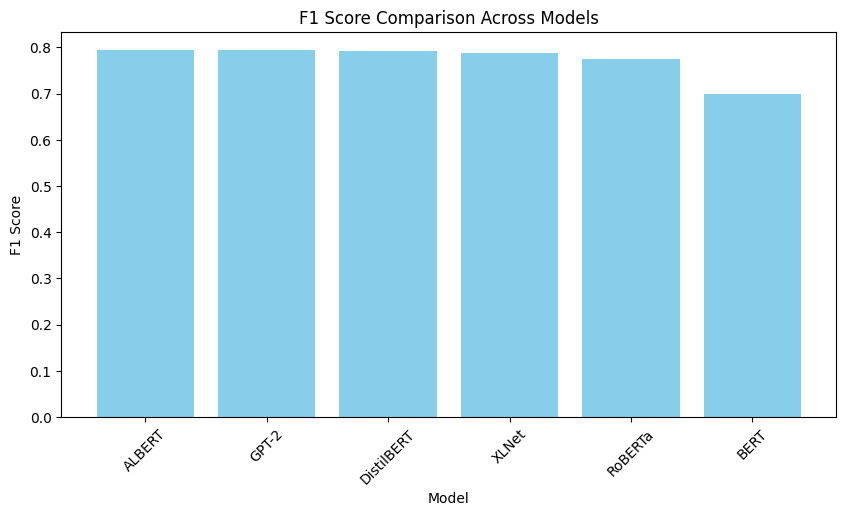

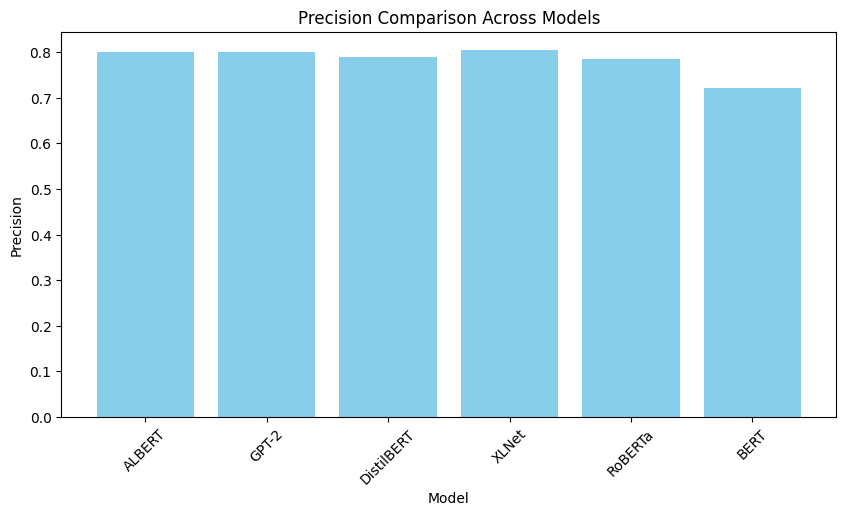

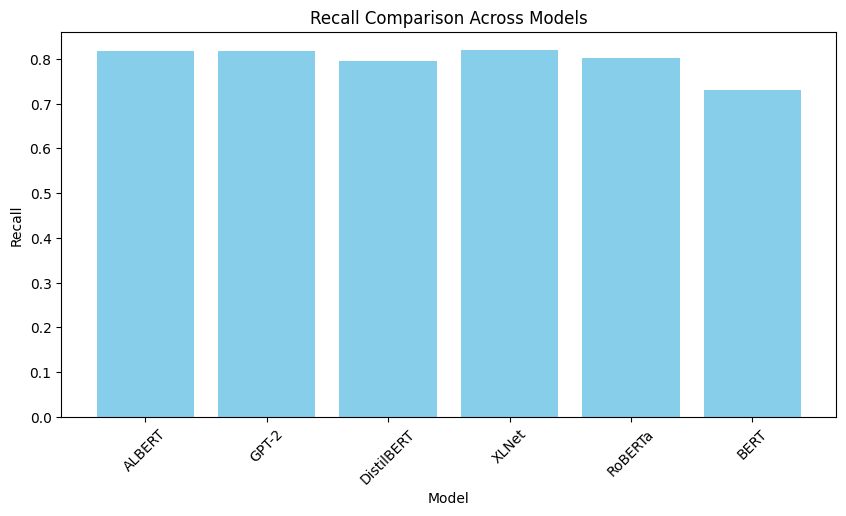

In [ ]:
# Compares the models core metrics against eachother using a bar plot
metrics = ["Accuracy", "F1 Score", "Precision", "Recall"]

for metric in metrics:
    plt.figure(figsize=(10, 5))
    plt.bar(sorted_results["Model"], sorted_results[metric], color="skyblue")
    plt.title(f'{metric} Comparison Across Models')
    plt.xlabel("Model")
    plt.ylabel(metric)
    plt.xticks(rotation=45)
    plt.show()

In [ ]:
# ANOVA or similar test to evalute the models against eachother.
# Omitted here...

In [ ]:
# Saves the core result metrics to a csv
sorted_results.to_csv("/content/drive/MyDrive/finetuned_models/evaluation_results.csv", index=False)